# Feature Engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np

In [2]:
df = pd.read_csv("../../data/processed/nba_ALL_SEASONS_MATCHED.csv")

# The below cell is a bunch of color util stuff I'll move elsewhere at some point

In [3]:
from typing import Tuple

TEAM_COLORS = {
    "ATL": {
        "primary": "#E03A3E",  # Hawks Red
        "secondary": "#C1D32F", # Volt Green
    },
    "BOS": {
        "primary": "#007A33",  # Celtics Green
        "secondary": "#BA9653", # Gold accent
    },
    "BKN": {
        "primary": "#111111",  # Black
        "secondary": "#EEEEEE", # White
    },
    "CHA": {
        "primary": "#1D1160",  # Teal/Purple
        "secondary": "#00788C", # Teal
    },
    "CHI": {
        "primary": "#CE1141",  # Bulls Red
        "secondary": "#111111", # Black
    },
    "CLE": {
        "primary": "#6F263D",  # Wine
        "secondary": "#FFB81C", # Gold
    },
    "DAL": {
        "primary": "#0056A0",  # Royal Blue
        "secondary": "#B8C4CA", # Silver
    },
    "DEN": {
        "primary": "#0E2240",  # Midnight Blue
        "secondary": "#FEC524", # Sunshine Yellow
    },
    "DET": {
        "primary": "#003D80",  # Pistons Blue
        "secondary": "#C8102E", # Red
    },
    "GSW": {
        "primary": "#1D428A",  # Royal Blue
        "secondary": "#FFC72C", # Golden Yellow
    },
    "HOU": {
        "primary": "#C8102E",  # Rockets Red
        "secondary": "#111111", # Black
    },
    "IND": {
        "primary": "#FDBB30",  # Yellow
        "secondary": "#002D62", # Navy
    },
    "LAC": {
        "primary": "#C8102E",  # Red
        "secondary": "#1D428A", # Blue
    },
    "LAL": {
        "primary": "#552583",  # Purple
        "secondary": "#FDB927", # Gold
    },
    "MEM": {
        "primary": "#5D76A9",  # Navy Blue
        "secondary": "#12173F", # Dark Blue
    },
    "MIA": {
        "primary": "#98002E",  # Heat Red
        "secondary": "#F9A01B", # Yellow/Orange
    },
    "MIL": {
        "primary": "#00471B",  # Green
        "secondary": "#EEE1C6", # Cream
    },
    "MIN": {
        "primary": "#236192",  # Blue
        "secondary": "#9EA2A2", # Gray
    },
    "NOP": {
        "primary": "#85714D",  # Metallic Gold
        "secondary": "#0C2340", # Navy
    },
    "NYK": {
        "primary": "#006BB6",  # Knicks Blue
        "secondary": "#F58426", # Orange
    },
    "OKC": {
        
        "primary": "#007AC1", # Thunder Blue
        "secondary": "#EF3B24",  # Sunset Orange
    },
    "ORL": {
        "primary": "#0077C0",  # Magic Blue
        "secondary": "#C4CED4", # Silver
    },
    "PHI": {
        "primary": "#E56020",  # Liberty Red/Orange
        "secondary": "#006BB6", # Blue
    },
    "PHX": {
        "primary": "#1D1160",  # Purple
        "secondary": "#E56020", # Orange
    },
    "POR": {
        "primary": "#E03A3E",  # Red
        "secondary": "#111111", # Black
    },
    "SAC": {
        "primary": "#5A2D81",  # Purple
        "secondary": "#63727A", # Gray
    },
    "SAS": {
        "primary": "#C4CED4",  # Silver
        "secondary": "#111111", # Black
    },
    "TOR": {
        "primary": "#BA0C2F",  # Red
        "secondary": "#111111", # Black
    },
    "UTA": {
        "primary": "#002B5C",  # Navy
        "secondary": "#F9A01B", # Gold
    },
    "WAS": {
        "primary": "#E31837",  # Red
        "secondary": "#002B5C", # Blue
    },
}


def hex_to_rgb(hex_color: str) -> Tuple[int, int, int]:
    """Convert hex color (e.g. '#RRGGBB') to RGB tuple."""
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


def color_distance(hex1: str, hex2: str) -> float:
    """Calculate Euclidean distance between two hex colors in RGB space."""
    r1, g1, b1 = hex_to_rgb(hex1)
    r2, g2, b2 = hex_to_rgb(hex2)
    return ((r1 - r2) ** 2 + (g1 - g2) ** 2 + (b1 - b2) ** 2) ** 0.5


def are_colors_too_similar(hex1: str, hex2: str, threshold: float = 30.0) -> bool:
    """Check if two hex colors are too similar."""
    return color_distance(hex1, hex2) < threshold


def get_primary_color(team: str) -> str:
    return TEAM_COLORS.get(team, {}).get("primary", "gray")


def get_secondary_color(team: str) -> str:
    return TEAM_COLORS.get(team, {}).get("secondary", "gray")


# Now time to make new features

In [4]:
# some of the easier ones

# making specific columns numeric if they aren't already
df['wl'] = df['wl'].map({'W': 1, 'L': 0})
df['whos_favored'] = df['whos_favored'].map({'home': 1, 'away': 0})

# theres some weirdness with the playin games, treating those games as playoffs
df.loc[(df['regular'] == False) & (df['playoffs'] == False), 'playoffs'] = True
df['part_of_season'] = df.apply(lambda row: 'playoffs' if row['playoffs'] else 'regular' , axis=1)

# making the spread in each line relative to the team
df['spread'] = df.apply(lambda row: row['spread'] if row['whos_favored'] == row['home_team'] else -row['spread'], axis=1)

# making the date column a datetime object
df['date'] = pd.to_datetime(df['date'])

# dropping columns that won't be used
df = df.drop(columns=['regular', 'playoffs', 'whos_favored'])

df = df.rename(columns={'team_abbreviation': 'team'})

In [5]:
# days of rest (defined as number of days in between games for a team)
df['days_since_prev_game'] = df.groupby('team')['date'].diff().dt.days
df['days_of_rest'] = df['days_since_prev_game'] - 1
df.loc[df['days_since_prev_game'].isna(), 'days_of_rest'] = pd.NA
df.loc[df['days_of_rest'] < 0, 'days_of_rest'] = 0
df['days_of_rest'] = df['days_of_rest'].astype('Int64').clip(upper=7)  # nullable integer
df = df.drop(columns=['days_since_prev_game'])

df['rest_category'] = pd.cut(
    df['days_of_rest'],
    bins=[-1, 0, 1, 2, 3, 5, 6],
    labels=['B2B','1 Day','2 Days','3 Days','4-5 Days','6+ Days']
)

df['season'] = df['date'].apply(lambda x: x.year if x.month >= 7 else x.year - 1)
df['team_season'] = df['team'].astype(str) + '_' + df['season'].astype(str)

In [6]:
# using an approximation for possessions here
df['poss'] = (df['fga'] + 0.44 * df['fta'] - df['oreb'] + df['tov']).round()

In [7]:
# opponent metrics (rolling averages, shooting stats, )
cols_to_copy =  [col for col in df.columns if 'avg_last' in col.lower()] + \
                ['fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'fta', 'ftm', 'ft_pct', 'poss', 'pts', 'tov', 'oreb', 'dreb', 'reb', 'days_of_rest']
cols_to_copy

df_with_opponent = df_with_opponent = df.merge(
    df[['game_id', 'team'] + cols_to_copy],  # Select game_id, team, and rolling columns
    on='game_id',
    suffixes=('', '_temp')
)

df_with_opponent = df_with_opponent[df_with_opponent['team'] != df_with_opponent['team_temp']]
rename_dict = {f'{col}_temp': f'opp_{col}' for col in cols_to_copy}
df_with_opponent = df_with_opponent.rename(columns=rename_dict)

df = df_with_opponent.drop('team_temp', axis=1)

In [8]:
# efficiency ratings
df['ortg'] = (df['pts'] / df['poss'] * 100)
df['drtg'] = (df['opp_pts'] / df['opp_poss'] * 100)
df['netrtg'] = (df['ortg'] - df['drtg'])

df['opp_ortg'] = df['drtg']
df['opp_drtg'] = df['ortg']

# effective field goal percentage
df['eFG_pct'] = ((df['fgm'] + 0.5 * df['fg3m']) / df['fga'])
df['opp_eFG_pct'] = ((df['opp_fgm'] + 0.5 * df['opp_fg3m']) / df['opp_fga'])

# turnover rate
df['tov_rate'] = (df['tov'] / df['poss'])
df['opp_tov_rate'] = (df['opp_tov'] / df['opp_poss'])

# offensive rebound rate
df['oreb_pct'] = (df['oreb'] / df['reb'])
df['opp_oreb_pct'] = (df['opp_oreb'] / df['opp_reb'])

# defensive rebound rate
df['dreb_pct'] = (df['dreb'] / df['reb'])
df['opp_dreb_pct'] = (df['opp_dreb'] / df['opp_reb'])

# free throw rate
df['ftr'] = (df['fta'] / df['fga'])
df['opp_ftr'] = (df['opp_fta'] / df['opp_fga'])

# margin of victory (or defeat)
df['margin'] = (df['pts'] - df['opp_pts'])
df['opp_margin'] = -df['margin']

In [9]:
# our actual target field (the most important one)
df['actual_diff'] = df['pts'] - df['opp_pts']
df['covered'] = (df['actual_diff'] + df['spread'] > 0).astype(int)

## Here's a bunch of columns we have now

The one's I'll probably end up using are 'ortg', 'drtg', 'opp_ortg', 'opp_drtg',
       'eFG_pct', 'opp_eFG_pct', 'opp_tov_rate', 'oreb_pct', 'opp_oreb_pct', 'ftr', 'opp_ftr'

subject to change obviously

## Now time to make some rolling average fields

In [10]:
# rolling averages for last 5, 10, 20 games for a few (lol) stats
windows = [5, 10, 20]
stats = ['pts', 'ast', 'reb', 'ortg', 'drtg', 'netrtg', 'eFG_pct', 'tov_rate', 'oreb_pct', 'dreb_pct', 'ftr', 'covered', 'margin']

for window in windows:
    for stat in stats:
        df[f'{stat}_avg_last_{window}'] = df.groupby('team_season')[stat].transform(
            lambda x: x.rolling(window, min_periods=1).mean().shift(1)
        )


In [11]:
def add_opponent_rolling_averages(df, rolling_avg_columns):
    """
    Copy rolling average columns from the opponent's row in the same game.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with game data where each game appears twice (once per team)
    rolling_avg_columns : list
        List of column names for rolling averages to copy from opponent
        e.g., ['pts_avg_last_5', 'ast_avg_last_5', 'reb_avg_last_5']
    
    Returns:
    --------
    pandas.DataFrame
        Original dataframe with added opponent rolling average columns
    """
    # Create a copy to avoid modifying original
    result_df = df.copy()
    
    # Create a mapping of game_id to teams
    game_teams = df.groupby('game_id')['team'].apply(list).to_dict()
    
    # Add opponent column
    result_df['opponent'] = result_df.apply(
        lambda row: [t for t in game_teams[row['game_id']] if t != row['team']][0],
        axis=1
    )
    
    # Create a lookup dictionary for each rolling average column
    for col in rolling_avg_columns:
        # Create lookup: (game_id, team) -> rolling average value
        lookup = result_df.set_index(['game_id', 'team'])[col].to_dict()
        
        # For each row, get the opponent's value for this rolling average
        opp_col_name = f'opp_{col}'
        result_df[opp_col_name] = result_df.apply(
            lambda row: lookup.get((row['game_id'], row['opponent']), np.nan),
            axis=1
        )
    return result_df

rolling_avg_cols = [col for col in df.columns if 'avg' in col]
df = add_opponent_rolling_averages(df, rolling_avg_cols)

In [12]:
def plot_with_gaps(ax, dates, values, **kwargs):
    # Sort by date first
    sort_idx = np.argsort(dates)
    dates = dates[sort_idx]
    values = values[sort_idx]
    
    # Convert dates to numbers for easier diff calculation
    dates_num = date2num(dates)
    # Find indices where the gap is more than 10 days
    gap_idx = dates_num[1:] - dates_num[:-1] > 14
    
    # Create a copy of values and insert NaN after each gap
    values_plot = values.copy()
    values_plot[np.where(gap_idx)[0] + 1] = np.nan
    
    ax.plot(dates, values_plot, **kwargs)

In [13]:
def abbrev_to_full_stat(abbrev):
    abbrev_dict = {
        'pts': 'points',
        'ast': 'assists',
        'reb': 'rebounds'
    }
    return abbrev_dict[abbrev]

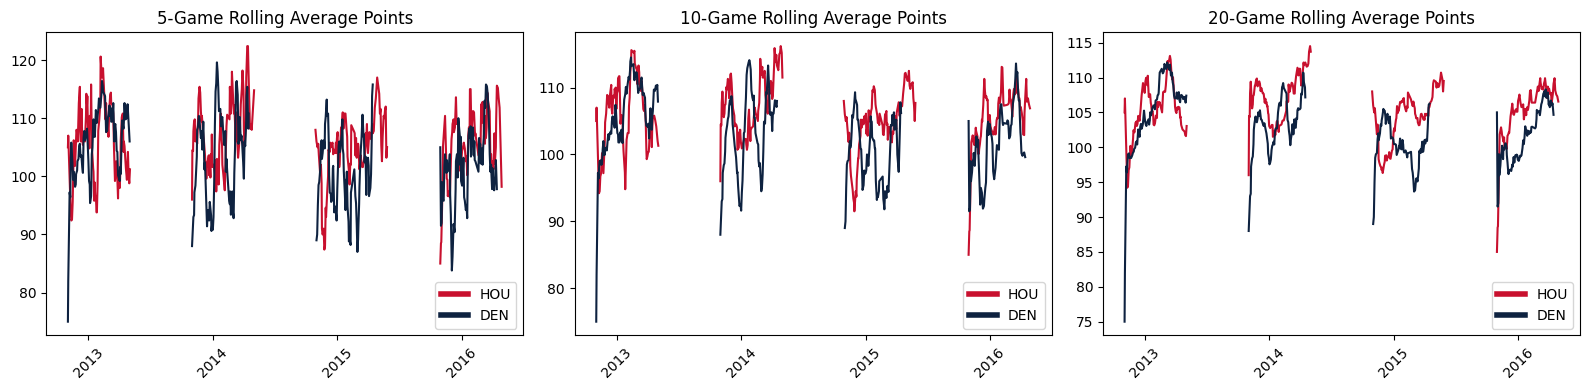

In [14]:
from matplotlib.lines import Line2D

def compare_rolling_stat(team1: str, team2: str, stat: str, windows: list = [5,10,20], start_date = pd.Timestamp('2022-10-01'), end_date = pd.Timestamp.today()):
    plt.subplots(figsize=(16, 4))
    plt.gca().set_axis_off() # gets rid of "figure" axis

    t1_color = get_primary_color(team1)
    t2_color = get_primary_color(team2)

    if are_colors_too_similar(t1_color, t2_color):
        t2_color = get_secondary_color(team2)

    leg_lines = [Line2D([0], [0], color=t1_color, lw=4),
             Line2D([0], [0], color=t2_color, lw=4)]


    for i in range(1,len(windows)+1):
        plt.subplot(1,3,i)

        ax = plt.gca()
        plot_with_gaps(
            ax,
            dates=df[(df['team'] == team1) & (df['date'] >= start_date) & (df['date'] <= end_date)]['date'].values,
            values=df[(df['team'] == team1) & (df['date'] >= start_date) & (df['date'] <= end_date)][f'{stat}_avg_last_{windows[i-1]}'].values,
            color=t1_color, label=team1
        )
        plot_with_gaps(
            ax,
            dates=df[(df['team'] == team2) & (df['date'] >= start_date) & (df['date'] <= end_date)]['date'].values,
            values=df[(df['team'] == team2) & (df['date'] >= start_date) & (df['date'] <= end_date)][f'{stat}_avg_last_{windows[i-1]}'].values,
            color=t2_color, label=team2
        )
        ax.legend(leg_lines, [team1, team2])
        plt.xticks(
            ticks=pd.date_range(start=start_date, end=end_date, freq='YS'),
            labels=[d.strftime('%Y') for d in pd.date_range(start=start_date, end=end_date, freq='YS')],
            rotation=45
        )
        plt.title(f'{windows[i-1]}-Game Rolling Average {abbrev_to_full_stat(stat).capitalize()}')

    plt.tight_layout()
    plt.show()

compare_rolling_stat('HOU', 'DEN', 'pts', start_date = pd.Timestamp('2012-10-01'), end_date = pd.Timestamp('2016-07-01'))

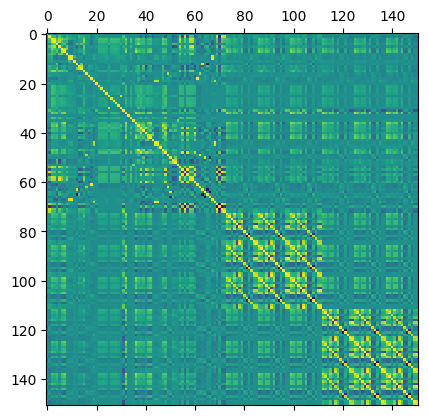

In [15]:
corr = df.select_dtypes(include='number').corr()

plt.matshow(corr)



## After creating some initial models, I had more ideas for advanced stats, as well as comparative stats


In [16]:
# rest_diff
df['rest_diff'] = (df['days_of_rest'] - df['opp_days_of_rest'])

# pace
df['pace'] = (48 * (df['poss'] + df['opp_poss']) / (2 * 240/5))
# pace rolling average
df['pace_last_10'] = df.groupby('team_season')['pace'].transform(
            lambda x: x.rolling(10, min_periods=1).mean().shift(1)
)
df = add_opponent_rolling_averages(df, ['pace_last_10'])
# pace_diff
df['pace_diff'] = (df['pace_last_10'] - df['opp_pace_last_10'])

# adj_off_eff (rolling average)
df['adj_off_eff'] = (df['ortg_avg_last_10'] - df['opp_drtg_avg_last_10'])
# adj_def_eff (rolling average)
df['adj_def_eff'] = (df['drtg_avg_last_10'] - df['opp_ortg_avg_last_10'])

# wl_last_10
df['wl_last_10'] = df.groupby('team_season')['wl'].transform(
            lambda x: x.rolling(10, min_periods=1).mean().shift(1)
)

# fatigue_index
df['fatigue_index'] = df.groupby('team_season')['days_of_rest'].transform(
    lambda x: x.rolling(3, min_periods=1).sum().shift(1)
)

# rebound_diff
df['rebound_last_10_diff'] = (df['oreb_pct_avg_last_10'] - df['opp_dreb_pct_avg_last_10'])

# turnover_diff
df['turnover_last_10_diff'] = (df['tov_rate_avg_last_10'] - df['opp_tov_rate_avg_last_10'])

# back_to_back
df['back_to_back'] = df['days_of_rest'] == 0

# spread_abs
df['spread_abs'] = df['spread'].apply(abs)

# interactive term between 

In [17]:
# Clean up temporary columns
df = df.drop(columns=[  
                        # 'season', 'team_season',
                        'fgm','fga','fg_pct','fg3m','fg3a','fg3_pct','ftm','fta','ft_pct','oreb','dreb','reb','ast','stl','blk','tov','pf',
                        'q1_away','q2_away','q3_away','q4_away','ot_away','q1_home','q2_home','q3_home','q4_home','ot_home',])

In [ ]:
from sklearn.preprocessing import StandardScaler

# find numeric columns and scale them in 

num_cols_to_scale = ['pts',
'spread',
'total',
'days_of_rest',
'poss',
'opp_fgm',
'opp_fga',
'opp_fg_pct',
'opp_fg3m',
'opp_fg3a',
'opp_fg3_pct',
'opp_fta',
'opp_ftm',
'opp_ft_pct',
'opp_poss',
'opp_pts',
'opp_tov',
'opp_oreb',
'opp_dreb',
'opp_reb',
'opp_days_of_rest',
'ortg',
'drtg',
'netrtg',
'opp_ortg',
'opp_drtg',
'eFG_pct',
'opp_eFG_pct',
'tov_rate',
'opp_tov_rate',
'oreb_pct',
'opp_oreb_pct',
'dreb_pct',
'opp_dreb_pct',
'ftr',
'opp_ftr',
'margin',
'opp_margin',
'actual_diff',
'pts_avg_last_5',
'ast_avg_last_5',
'reb_avg_last_5',
'ortg_avg_last_5',
'drtg_avg_last_5',
'netrtg_avg_last_5',
'eFG_pct_avg_last_5',
'tov_rate_avg_last_5',
'oreb_pct_avg_last_5',
'dreb_pct_avg_last_5',
'ftr_avg_last_5',
'covered_avg_last_5',
'margin_avg_last_5',
'pts_avg_last_10',
'ast_avg_last_10',
'reb_avg_last_10',
'ortg_avg_last_10',
'drtg_avg_last_10',
'netrtg_avg_last_10',
'eFG_pct_avg_last_10',
'tov_rate_avg_last_10',
'oreb_pct_avg_last_10',
'dreb_pct_avg_last_10',
'ftr_avg_last_10',
'covered_avg_last_10',
'margin_avg_last_10',
'pts_avg_last_20',
'ast_avg_last_20',
'reb_avg_last_20',
'ortg_avg_last_20',
'drtg_avg_last_20',
'netrtg_avg_last_20',
'eFG_pct_avg_last_20',
'tov_rate_avg_last_20',
'oreb_pct_avg_last_20',
'dreb_pct_avg_last_20',
'ftr_avg_last_20',
'covered_avg_last_20',
'margin_avg_last_20',
'opp_pts_avg_last_5',
'opp_ast_avg_last_5',
'opp_reb_avg_last_5',
'opp_ortg_avg_last_5',
'opp_drtg_avg_last_5',
'opp_netrtg_avg_last_5',
'opp_eFG_pct_avg_last_5',
'opp_tov_rate_avg_last_5',
'opp_oreb_pct_avg_last_5',
'opp_dreb_pct_avg_last_5',
'opp_ftr_avg_last_5',
'opp_covered_avg_last_5',
'opp_margin_avg_last_5',
'opp_pts_avg_last_10',
'opp_ast_avg_last_10',
'opp_reb_avg_last_10',
'opp_ortg_avg_last_10',
'opp_drtg_avg_last_10',
'opp_netrtg_avg_last_10',
'opp_eFG_pct_avg_last_10',
'opp_tov_rate_avg_last_10',
'opp_oreb_pct_avg_last_10',
'opp_dreb_pct_avg_last_10',
'opp_ftr_avg_last_10',
'opp_covered_avg_last_10',
'opp_margin_avg_last_10',
'opp_pts_avg_last_20',
'opp_ast_avg_last_20',
'opp_reb_avg_last_20',
'opp_ortg_avg_last_20',
'opp_drtg_avg_last_20',
'opp_netrtg_avg_last_20',
'opp_eFG_pct_avg_last_20',
'opp_tov_rate_avg_last_20',
'opp_oreb_pct_avg_last_20',
'opp_dreb_pct_avg_last_20',
'opp_ftr_avg_last_20',
'opp_covered_avg_last_20',
'opp_margin_avg_last_20',
'rest_diff',
'pace',
'pace_last_10',
'opp_pace_last_10',
'pace_diff',
'adj_off_eff',
'adj_def_eff',
'wl_last_10',
'fatigue_index',
'rebound_last_10_diff',
'turnover_last_10_diff',
'spread_abs']

scaler = StandardScaler()
df[num_cols_to_scale] = scaler.fit_transform(df[num_cols_to_scale])

['team',
 'game_id',
 'date',
 'wl',
 'pts',
 'home_team',
 'spread',
 'total',
 'id_spread',
 'id_total',
 'part_of_season',
 'days_of_rest',
 'rest_category',
 'season',
 'team_season',
 'poss',
 'opp_fgm',
 'opp_fga',
 'opp_fg_pct',
 'opp_fg3m',
 'opp_fg3a',
 'opp_fg3_pct',
 'opp_fta',
 'opp_ftm',
 'opp_ft_pct',
 'opp_poss',
 'opp_pts',
 'opp_tov',
 'opp_oreb',
 'opp_dreb',
 'opp_reb',
 'opp_days_of_rest',
 'ortg',
 'drtg',
 'netrtg',
 'opp_ortg',
 'opp_drtg',
 'eFG_pct',
 'opp_eFG_pct',
 'tov_rate',
 'opp_tov_rate',
 'oreb_pct',
 'opp_oreb_pct',
 'dreb_pct',
 'opp_dreb_pct',
 'ftr',
 'opp_ftr',
 'margin',
 'opp_margin',
 'actual_diff',
 'covered',
 'pts_avg_last_5',
 'ast_avg_last_5',
 'reb_avg_last_5',
 'ortg_avg_last_5',
 'drtg_avg_last_5',
 'netrtg_avg_last_5',
 'eFG_pct_avg_last_5',
 'tov_rate_avg_last_5',
 'oreb_pct_avg_last_5',
 'dreb_pct_avg_last_5',
 'ftr_avg_last_5',
 'covered_avg_last_5',
 'margin_avg_last_5',
 'pts_avg_last_10',
 'ast_avg_last_10',
 'reb_avg_last_10',
 '

## Just gonna save all of the features now that they're computed

In [24]:
df = df.dropna()
df.to_csv("../../data/processed/engineered.csv", index=False)